In [1]:
import sys

sys.path.append('./helpers_models/')
sys.path.append('./data_visualization_and_augmentations/')
sys.path.append('../torch_videovision/')
sys.path.append('./important_csvs/')

from helpers_resnet import *

resnet = torchvision.models.resnet50(pretrained=True)
adaptive_pooling = AdaptiveConcatPool2d()
head = Head()
resnet.avgpool = adaptive_pooling
resnet.fc = head

os.environ['CUDA_VISIBLE_DEVICES']='0,1,2'

resnet = resnet.cuda()

for param in resnet.parameters():
    param.requires_grad = False
    
for param in resnet.avgpool.parameters():
    param.requires_grad = True
    
for param in resnet.fc.parameters():
    param.requires_grad = True

resnet = nn.DataParallel(resnet)
check_freeze(resnet.module)

conv1 False
bn1 False
relu True
maxpool True
layer1 False
layer2 False
layer3 False
layer4 False
avgpool True
fc True


In [2]:
tensor_transform = get_tensor_transform('ImageNet', True)
train_spat_transform = get_spatial_transform(2)
train_temp_transform = get_temporal_transform()
valid_spat_transform = get_spatial_transform(0)
valid_temp_transform = va.TemporalFit(size=16)

root_dir = '/media/scratch/astamoulakatos/nsea_video_jpegs/'
df = pd.read_csv('./small_dataset_csvs/events_with_number_of_frames_stratified.csv')
df_train = get_df(df, 20, False, True, False)
class_image_paths, end_idx = get_indices(df_train, root_dir)
train_loader = get_loader(16, 1, end_idx, class_image_paths, train_temp_transform, train_spat_transform, tensor_transform, False, False)
df_valid = get_df(df, 20, False, True, False)
class_image_paths, end_idx = get_indices(df_valid, root_dir)
valid_loader = get_loader(16, 1, end_idx, class_image_paths, valid_temp_transform, valid_spat_transform, tensor_transform, False, False)
df_test = get_df(df, 20, False, False, True)
class_image_paths, end_idx = get_indices(df_test, root_dir)
test_loader = get_loader(16, 1, end_idx, class_image_paths, valid_temp_transform, valid_spat_transform, tensor_transform, False, False)

torch.cuda.empty_cache()

In [3]:
from sklearn.metrics import precision_score,f1_score, accuracy_score, jaccard_score

In [4]:
inputs, classes = next(iter(train_loader))

In [5]:
inputs.shape

torch.Size([1, 3, 16, 288, 352])

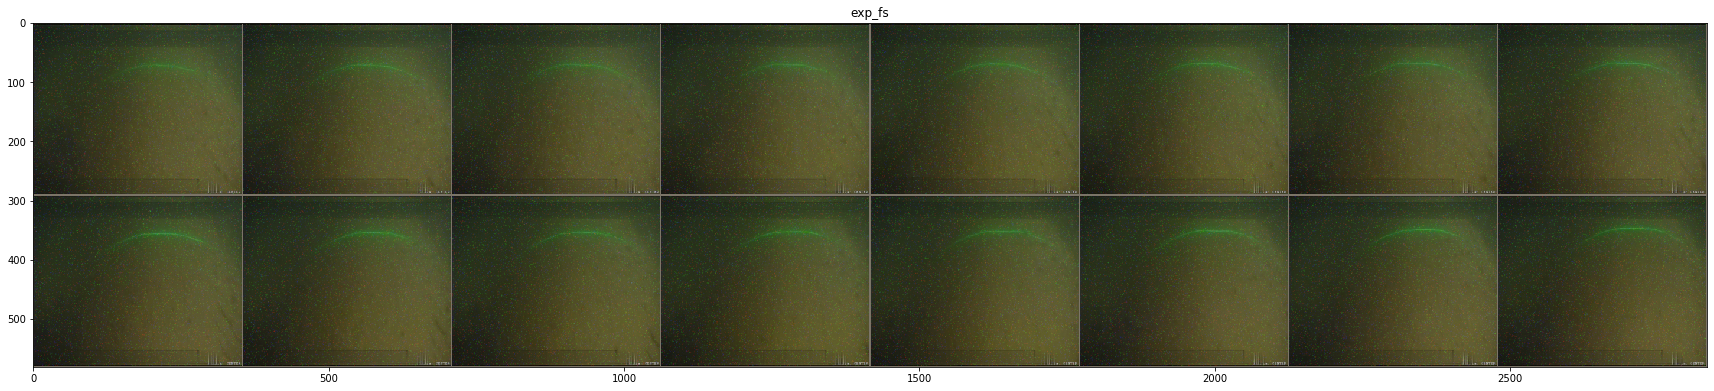

In [6]:
show_batch(train_loader, 1)

In [22]:
resnet.eval()
running_loss = 0.0
running_acc = 0.0  
running_f1 = 0.0
valid_result = []
rolling_preds = np.zeros(5)
y_pred = []
y_true = []
with torch.no_grad():
    for X, y in valid_loader:
        X = X.cuda()
        y = Variable(y.float()).cuda()
        X = X.squeeze(dim=0)
        X = X.permute(1,0,2,3)
        y = y.squeeze(dim=0)
        y = y.float()
        output = resnet(X)
        preds = torch.sigmoid(output) #.data > 0.5  
        preds = preds.to(torch.float32)  
        preds = preds.detach().cpu().numpy()
        cl1 = []
        cl2 = []
        cl3 = []
        cl4 = []
        cl5 = []
        for p in preds:
            cl1.append(p[0])
            cl2.append(p[1])
            cl3.append(p[2])
            cl4.append(p[3])
            cl5.append(p[4])

        if (np.mean(cl1) > 0.5):
            rolling_preds[0] = 1
        else:
            rolling_preds[0] = 0

        if (np.mean(cl2) > 0.7):
            rolling_preds[1] = 1
        else:
            rolling_preds[1] = 0   

        if (np.mean(cl3) > 0.3):
            rolling_preds[2] = 1
        else:
            rolling_preds[2] = 0

        if (np.mean(cl4) > 0.8):
            rolling_preds[3] = 1
        else:
            rolling_preds[3] = 0 

        if (np.mean(cl5) > 0.8):
            rolling_preds[4] = 1
        else:
            rolling_preds[4] = 0        

        #running_acc += accuracy_score(y.detach().cpu().numpy(), rolling_preds) *  X.size(0)
        #running_f1 += f1_score(y.detach().cpu().numpy(), (rolling_preds), average="samples")  *  X.size(0)
        y_pred.append(rolling_preds)
        y_true.append(y.detach().cpu().numpy())

# epoch_acc = running_acc / len(valid_loader.dataset)
# epoch_f1 = running_f1 / len(valid_loader.dataset)

# valid_result.append('Validation Acc: {:.4f} F1: {:.4f}'.format(epoch_acc, epoch_f1))
# print(valid_result)

In [23]:
from helpers_thresholds import *

In [24]:
rolling_preds

array([0., 0., 1., 0., 0.])

In [25]:
y_true

[array([1., 0., 0., 0., 0.], dtype=float32),
 array([0., 1., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 0.], dtype=float32),
 array([0., 1., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 1.], dtype=float32),
 array([1., 0., 0., 0., 1.], dtype=float32),
 array([1., 0., 1., 0., 0.], dtype=float32),
 array([0., 1., 0., 0., 0.], dtype=float32),
 array([0., 1., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 1.], dtype=float32),
 array([1., 0., 0., 0., 1.], dtype=float32),
 array([1., 0., 0., 1., 0.], dtype=float32),
 array([1., 0., 0., 0., 1.], dtype=float32),
 array([1., 0., 1., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 1.], dtype=float32),
 array([1., 0., 0., 0., 0.], dtype=float32),
 array([0., 1., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 1.], dtype=float32),
 array([1., 0., 0., 0., 0.], dtype=float32),
 array([1., 0., 0., 0., 0.], dtype=float32),
 array([0., 1., 0., 0., 0.], dtype=float32),
 array([1.

In [26]:
y_pred

[array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0., 0., 1., 0., 0.]),
 array([0.

In [11]:
classes = ['Exposure', 'Burial', 'Field Joint', 'Anode', 'Free Span']

In [13]:
thresholds = nsea_compute_thresholds(y_true, y_pred, classes)

TypeError: list indices must be integers or slices, not tuple

In [16]:
thresholds

{'Exposure': 0.5549621,
 'Burial': 0.7895948,
 'Field Joint': 0.38403448,
 'Anode': 0.9837944,
 'Free Span': 0.97246337}

## validation set

In [19]:
new_compute_metrics(y_tr, y_pr, thresholds, classes)

/home/astamoulakatos/.conda/envs/deep/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Event,Threshold,Exact Matching Score,Precision,Recall,F1-Score,tn,fp,fn,tp
0,Exposure,0.554962,0.887344,0.915709,0.929760,0.922681,1377.0,396.0,325.0,4302.0
1,Burial,0.789595,0.885781,0.768834,0.840384,0.803018,4179.0,448.0,283.0,1490.0
2,Field Joint,0.384034,0.908125,0.647500,0.977358,0.778947,4776.0,564.0,24.0,1036.0
3,Anode,0.983794,0.944219,0.833935,0.426199,0.564103,5812.0,46.0,311.0,231.0
4,Free Span,0.972463,0.998281,0.997245,0.997703,0.997474,4217.0,6.0,5.0,2172.0
5,Aggregate,NaN,0.772031,0.846667,0.880078,0.856281,NaN,NaN,NaN,NaN


## test set

In [20]:
resnet.eval()
running_loss = 0.0
running_acc = 0.0  
running_f1 = 0.0
valid_result = []
rolling_preds = np.zeros(5)
y_pred = []
y_true = []
with torch.no_grad():
    for X, y in test_loader:
        X = X.cuda()
        y = Variable(y.float()).cuda()
        X = X.squeeze(dim=0)
        X = X.permute(1,0,2,3)
        y = y.squeeze(dim=0)
        y = y.float()
        output = resnet(X)
        preds = torch.sigmoid(output) #.data > 0.5  
        preds = preds.to(torch.float32)  
        preds = preds.detach().cpu().numpy()
        cl1 = []
        cl2 = []
        cl3 = []
        cl4 = []
        cl5 = []
        for p in preds:
            cl1.append(p[0])
            cl2.append(p[1])
            cl3.append(p[2])
            cl4.append(p[3])
            cl5.append(p[4])

        if (np.mean(cl1) > 0.5):
            rolling_preds[0] = 1
        else:
            rolling_preds[0] = 0

        if (np.mean(cl2) > 0.5):
            rolling_preds[1] = 1
        else:
            rolling_preds[1] = 0   

        if (np.mean(cl3) > 0.5):
            rolling_preds[2] = 1
        else:
            rolling_preds[2] = 0

        if (np.mean(cl4) > 0.5):
            rolling_preds[3] = 1
        else:
            rolling_preds[3] = 0 

        if (np.mean(cl5) > 0.5):
            rolling_preds[4] = 1
        else:
            rolling_preds[4] = 0        

        #running_acc += accuracy_score(y.detach().cpu().numpy(), rolling_preds) *  X.size(0)
        #running_f1 += f1_score(y.detach().cpu().numpy(), (rolling_preds), average="samples")  *  X.size(0)
        y_pred.append(rolling_preds)
        y_true.append(y.detach().cpu().numpy())

# epoch_acc = running_acc / len(valid_loader.dataset)
# epoch_f1 = running_f1 / len(valid_loader.dataset)

# valid_result.append('Validation Acc: {:.4f} F1: {:.4f}'.format(epoch_acc, epoch_f1))
# print(valid_result)

In [23]:
new_compute_metrics(y_tr, y_pr, thresholds, classes)

,Event,Threshold,Exact Matching Score,Precision,Recall,F1-Score,tn,fp,fn,tp
0,Exposure,0.554962,0.817560,0.863043,0.869470,0.866245,1524.0,630.0,596.0,3970.0
1,Burial,0.789595,0.825000,0.711872,0.762767,0.736441,3901.0,665.0,511.0,1643.0
2,Field Joint,0.384034,0.826935,0.460934,0.934263,0.617308,4619.0,1097.0,66.0,938.0
3,Anode,0.983794,0.927530,0.715134,0.381329,0.497420,5992.0,96.0,391.0,241.0
4,Free Span,0.972463,0.993750,1.000000,0.978958,0.989367,4724.0,0.0,42.0,1954.0
5,Aggregate,NaN,0.674554,0.772297,0.805357,0.778105,NaN,NaN,NaN,NaN
